# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [2]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 87 ms, sys: 47 ms, total: 134 ms
Wall time: 246 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1,...,Card_dow_count_14,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since,Cardnum_unique_count_for_card_state_14,Cardnum_actual/max_1,Cardnum_unique_count_for_card_zip_14,Recnum,Fraud
0,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,3.62,1,1.0,...,1,1,1,1461.0,1461.0,1,1.0,1,1,0
1,1,31.42,0.001111,31.42,0.000098,31.42,0.000278,31.42,1,1.0,...,1,1,1,1461.0,1461.0,1,1.0,1,2,0
2,1,178.49,0.001111,178.49,0.000098,178.49,0.000278,178.49,1,1.0,...,1,1,1,1461.0,1461.0,1,1.0,1,3,0
3,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,3.62,1,1.0,...,1,1,1,1461.0,1461.0,1,1.0,1,4,0
4,1,7.24,0.001111,3.62,0.142857,3.62,0.000278,7.24,1,0.5,...,2,1,1,0.0,0.0,1,1.0,1,5,0


In [4]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_total_7',
 'Cardnum_count_1_by_30_sq',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by7',
 'card_state_max_7',
 'card_zip_count_1_by_60_sq',
 'Merchnum_desc_total_3',
 'Cardnum_unique_count_for_card_state_3',
 'Cardnum_actual/toal_1']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
0,1,0,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,3.62,1,1.0
1,2,0,1,31.42,0.001111,31.42,0.000098,31.42,0.000278,31.42,1,1.0
2,3,0,1,178.49,0.001111,178.49,0.000098,178.49,0.000278,178.49,1,1.0
3,4,0,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,3.62,1,1.0
4,5,0,1,7.24,0.001111,3.62,0.142857,3.62,0.000278,7.24,1,0.5


In [6]:
vars.shape

(97496, 12)

In [7]:
vars['Fraud'].sum()

2047

In [8]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
0,1,0,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,3.62,1,1.000000
1,2,0,1,31.42,0.001111,31.42,0.000098,31.42,0.000278,31.42,1,1.000000
2,3,0,1,178.49,0.001111,178.49,0.000098,178.49,0.000278,178.49,1,1.000000
3,4,0,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,3.62,1,1.000000
4,5,0,1,7.24,0.001111,3.62,0.142857,3.62,0.000278,7.24,1,0.500000
5,6,0,1,3.67,0.001111,3.67,0.000098,3.67,0.000278,3.67,1,1.000000
6,7,0,1,3.62,0.001111,3.62,0.000098,3.62,0.000278,7.24,1,1.000000
7,8,0,1,230.32,0.001111,230.32,0.000098,230.32,0.000278,230.32,1,1.000000
8,9,0,1,62.11,0.001111,62.11,0.000098,62.11,0.000278,62.11,1,1.000000
9,10,0,1,10.86,0.001111,3.62,0.142857,3.62,0.000278,10.86,1,0.333333


In [10]:
vars.shape

(97496, 12)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,9.749600e+04,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.717953,0.000294,1194.385741,0.047073,539.204983,1.837458e-04,1413.522502,2.169822,0.629566
std,28262.212670,0.143371,1.568565,4074.945381,0.000279,1856.894526,0.058449,1123.875852,1.017907e-04,5123.214335,1.921436,0.396178
min,1.000000,0.000000,1.000000,0.010000,0.000003,0.140000,0.000078,0.010000,5.078204e-07,0.010000,1.000000,0.000014
25%,24428.750000,0.000000,1.000000,52.500000,0.000108,307.000000,0.003968,56.000000,9.259259e-05,99.900000,1.000000,0.201645
50%,48916.000000,0.000000,1.000000,189.000000,0.000185,801.660000,0.008929,215.000000,2.777778e-04,356.595000,2.000000,0.813617
75%,73402.250000,0.000000,2.000000,590.000000,0.000370,1743.000000,0.107143,624.000000,2.777778e-04,1325.652500,3.000000,1.000000
max,97852.000000,1.000000,21.000000,306633.410000,0.001111,47900.000000,0.142857,47900.000000,2.777778e-04,307302.580000,22.000000,1.000000


In [12]:
# find the row i vars that corresponds to 11/1 for the oot
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
84935,85265,0,1,174.61,0.000556,225.00,0.000635,174.61,0.000139,174.61,1,1.0
84936,85266,0,1,53.00,0.000093,395.00,0.009524,206.90,0.000025,53.00,1,1.0
84937,85267,0,1,25.00,0.000159,531.25,0.008929,25.00,0.000093,25.00,1,1.0
84938,85268,0,1,97.17,0.000159,395.04,0.003322,97.17,0.000278,97.17,1,1.0
84939,85269,0,1,6.51,0.000556,6.51,0.002857,6.51,0.000093,6.51,1,1.0
84940,85270,0,1,170.00,0.000556,170.00,0.002232,170.00,0.000278,170.00,1,1.0
84941,85271,0,1,250.00,0.000085,250.00,0.008929,250.00,0.000278,250.00,2,1.0
84942,85272,0,1,15.00,0.000556,103.60,0.002857,15.00,0.000278,15.00,2,1.0
84943,85273,0,1,300.00,0.000222,2105.00,0.003968,2105.00,0.000035,300.00,1,1.0
84944,85274,0,1,133.20,0.000085,268.20,0.008929,97.02,0.000046,133.20,2,1.0


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,9.749600e+04,97496.000000,97496.000000,97496.000000
mean,1.724266,676.717953,0.000294,1194.385741,0.047073,539.204983,1.837458e-04,1413.522502,2.169822,0.629566
std,1.568565,4074.945381,0.000279,1856.894526,0.058449,1123.875852,1.017907e-04,5123.214335,1.921436,0.396178
min,1.000000,0.010000,0.000003,0.140000,0.000078,0.010000,5.078204e-07,0.010000,1.000000,0.000014
25%,1.000000,52.500000,0.000108,307.000000,0.003968,56.000000,9.259259e-05,99.900000,1.000000,0.201645
50%,1.000000,189.000000,0.000185,801.660000,0.008929,215.000000,2.777778e-04,356.595000,2.000000,0.813617
75%,2.000000,590.000000,0.000370,1743.000000,0.107143,624.000000,2.777778e-04,1325.652500,3.000000,1.000000
max,21.000000,306633.410000,0.001111,47900.000000,0.142857,47900.000000,2.777778e-04,307302.580000,22.000000,1.000000


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# use this to cap variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,-3.469048e-17,-5.538817e-18,-5.830333e-19,1.836555e-17,6.996400e-18,-7.579433e-18,-2.332133e-17,2.332133e-18,3.906323e-17,8.162467e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346955e-01,-1.044444e+00,-7.194261e-01,-8.040309e-01,-5.989859e-01,-1.800145e+00,-4.318703e-01,-6.089466e-01,-1.589062e+00
25%,-4.651796e-01,-3.066096e-01,-6.685133e-01,-5.318162e-01,-7.374772e-01,-5.352328e-01,-8.954968e-01,-3.999577e-01,-6.089466e-01,-1.080121e+00
50%,-4.651796e-01,-2.335723e-01,-3.902418e-01,-2.293881e-01,-6.526120e-01,-3.541873e-01,9.237778e-01,-3.179495e-01,-8.838071e-02,4.645672e-01
75%,1.782986e-01,-1.900840e-02,2.733285e-01,3.461339e-01,1.027719e+00,1.115210e-01,9.237778e-01,-8.357432e-03,4.321852e-01,9.350196e-01
max,1.009425e+01,2.183128e+01,2.927610e+00,1.136351e+01,1.638749e+00,1.281199e+01,9.237778e-01,1.638723e+01,1.000236e+01,9.350196e-01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [19]:
len(X_trntst.columns)

10

In [20]:
X_trntst_save = X_trntst.copy()

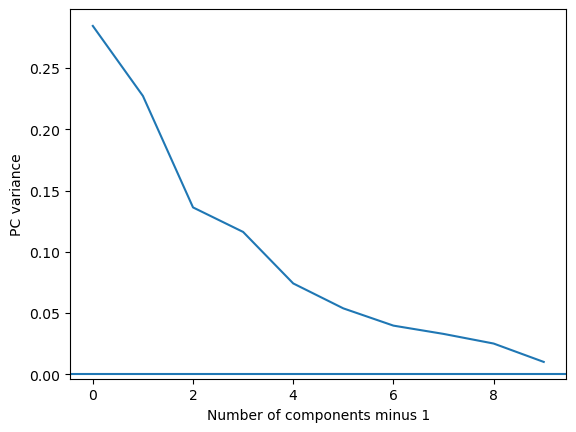

In [21]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.508048,0.219553,-2.833981,0.515411
1,-1.480270,0.242812,-2.832143,0.512289
2,-1.333318,0.365856,-2.822418,0.495775
3,-1.508048,0.219553,-2.833981,0.515411
4,-0.521834,-1.045867,-2.499627,2.255834


In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,-0.035000,-0.876950,-0.045096,-0.026600
85265,-0.194294,-1.232263,-2.373844,2.486175
85266,0.673233,2.375459,-0.961198,-0.435255
85267,0.088093,-0.525810,-0.105104,-0.504546
85268,-0.982251,1.026002,-0.496349,-0.667275


In [24]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002805,-0.013411,0.003866,0.004760,0.002290,-0.016298,0.011371,0.006726,-0.009701
std,1.007299,1.029151,0.996083,0.988241,1.000962,1.009247,1.008192,1.038862,1.007166,1.001578
min,-0.465180,-0.334696,-1.044444,-0.719426,-0.803986,-0.598986,-1.800145,-0.431870,-0.608947,-1.589062
25%,-0.465180,-0.307467,-0.680554,-0.528478,-0.737477,-0.537524,-0.895497,-0.400158,-0.608947,-1.087599
50%,-0.465180,-0.234966,-0.390242,-0.220376,-0.652612,-0.355326,0.675695,-0.318790,-0.088381,0.421275
75%,0.178299,-0.019273,0.273329,0.354082,1.027719,0.112819,0.923778,-0.004191,0.432185,0.935020
max,10.094246,21.831284,2.927610,11.363510,1.638749,12.811994,0.923778,16.387231,10.002362,0.935020


In [25]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.113119,0.018661,-0.175648,-0.023629
std,1.519190,1.371710,1.122667,1.042098
min,-1.763223,-9.320464,-2.972495,-6.275779
25%,-1.198375,-0.774519,-0.791160,-0.649192
50%,-0.417053,0.365064,-0.275281,-0.216831
75%,0.507730,0.693104,0.726283,0.524063
max,23.839786,19.977768,3.418273,6.764951


In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,-1.266683e-17,-1.866691e-17,-1.066681e-17,-9.333457e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.047597e+00,-6.236880e+00,-2.808495e+00,-8.694856e+00
25%,-6.501677e-01,-5.757865e-01,-5.627140e-01,-6.011773e-01
50%,-1.920747e-01,1.885184e-01,-9.791095e-02,-1.750268e-01
75%,3.475305e-01,4.608554e-01,8.156383e-01,5.248792e-01
max,1.472752e+01,1.368711e+01,2.951083e+00,8.956990e+00


In [28]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.066504,0.012273,-0.149187,-0.021729
std,0.893150,0.902193,0.953539,0.958282
min,-1.036620,-6.130197,-2.524693,-5.771019
25%,-0.704539,-0.509412,-0.671973,-0.596977
50%,-0.245190,0.240108,-0.233810,-0.199392
75%,0.298501,0.455864,0.616869,0.481912
max,14.015703,13.139652,2.903316,6.220848


In [29]:
X_trntst_pca.shape

(85264, 4)

In [30]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


In [32]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6942148760330579 0.6703703703703704 0.48148148148148145
1 0.6941467436108821 0.6741154562383612 0.48148148148148145
2 0.6876996805111821 0.6767068273092369 0.48484848484848486
3 0.6858080393765381 0.6949152542372882 0.48148148148148145
4 0.6888708367181153 0.6897880539499036 0.4781144781144781
5 0.68561872909699 0.6931407942238267 0.4781144781144781
6 0.6758286176232822 0.7115009746588694 0.4713804713804714
7 0.6817434210526315 0.702247191011236 0.4781144781144781
8 0.6910953506698188 0.681912681912682 0.4781144781144781
9 0.6884709730171709 0.6793168880455408 0.48148148148148145
trn    0.687350
tst    0.687401
oot    0.479461
dtype: float64
CPU times: user 4.34 s, sys: 70.6 ms, total: 4.41 s
Wall time: 995 ms


In [35]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(splitter='best', max_depth=50, min_samples_leaf=100)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7428337428337428 0.7051039697542533 0.5757575757575758
1 0.7403846153846154 0.7091633466135459 0.5454545454545454
2 0.7366720516962844 0.693359375 0.5454545454545454
3 0.7491666666666666 0.7381818181818182 0.5151515151515151
4 0.728225806451613 0.7137254901960784 0.5993265993265994
5 0.7497962510187449 0.6959847036328872 0.6094276094276094
6 0.7586206896551724 0.6809269162210339 0.5757575757575758
7 0.7532894736842105 0.6947565543071161 0.5420875420875421
8 0.7390612569610183 0.7119675456389453 0.5555555555555556
9 0.7397372742200329 0.7030075187969925 0.5218855218855218
trn    0.743779
tst    0.704618
oot    0.558586
dtype: float64
CPU times: user 5.97 s, sys: 4.7 ms, total: 5.97 s
Wall time: 5.84 s


In [36]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = RandomForestClassifier(criterion='gini', max_depth=20, min_samples_leaf=60, n_estimators=50)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7810985460420032 0.744140625 0.5488215488215489
1 0.7750611246943765 0.7648183556405354 0.5757575757575758
2 0.7798165137614679 0.7549909255898367 0.5555555555555556
3 0.7755102040816326 0.7771428571428571 0.5757575757575758
4 0.7718174539631706 0.7524950099800399 0.5454545454545454
5 0.7844408427876823 0.751937984496124 0.5656565656565656
6 0.7773212818405916 0.7485928705440901 0.569023569023569
7 0.7825370675453048 0.7574626865671642 0.5622895622895623
8 0.7820097244732577 0.7596899224806202 0.5757575757575758
9 0.7811023622047244 0.7791666666666667 0.5656565656565656
trn    0.779072
tst    0.759044
oot    0.563973
dtype: float64
CPU times: user 47 s, sys: 0 ns, total: 47 s
Wall time: 47 s


In [37]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(subsample=1, max_depth=2, learning_rate=0.1, n_estimators=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1211, number of negative: 58473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020290 -> initscore=-3.877119
[LightGBM] [Info] Start training from score -3.877119
0 0.7770437654830719 0.7235621521335807 0.5555555555555556
[LightGBM] [Info] Number of positive: 1225, number of negative: 58459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary

In [38]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [40]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = MLPClassifier(hidden_layer_sizes=(5,5), activation='tanh', solver='adam', alpha=0.1)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7333333333333333 0.7403846153846154 0.5286195286195287
1 0.7336065573770492 0.7339622641509433 0.531986531986532
2 0.7262388302193339 0.7456647398843931 0.5420875420875421
3 0.7373653686826843 0.7403314917127072 0.5622895622895623
4 0.7177033492822966 0.7540322580645161 0.5050505050505051
5 0.7305194805194806 0.7355212355212355 0.5117845117845118
6 0.7306733167082294 0.7257769652650823 0.5488215488215489
7 0.7263681592039801 0.7444852941176471 0.5622895622895623
8 0.7398042414355628 0.7156488549618321 0.5521885521885522
9 0.7372675828617623 0.7212475633528265 0.5353535353535354
trn    0.731288
tst    0.735706
oot    0.538047
dtype: float64
CPU times: user 20.3 s, sys: 62.9 ms, total: 20.3 s
Wall time: 16.4 s


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
#                           max_iter=1000,learning_rate='adaptive',learning_rate_init=.01)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(learning_rate=0.01,max_depth=4,n_estimators=300)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [43]:
# %%time
# # Catboost

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     # X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [44]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier(num_leaves=4,n_estimators=30)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=100)
# #             learning_rate=detect_rate,
# #             l2_leaf_reg=5  
# #

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [47]:
# %%time
# # XGB

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# #     model = xgb.XGBClassifier(booster='gbtree',max_depth=4,min_child_weight=75,gamma=0.01)
#     model = xgb.XGBClassifier(booster='gbtree',n_estimators=70,max_depth=3,learning_rate=.1)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [48]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#     model = KNeighborsClassifier(n_neighbors=80) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [50]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.694215,0.67037,0.481481
1,log reg,0.694147,0.674115,0.481481
2,log reg,0.6877,0.676707,0.484848
3,log reg,0.685808,0.694915,0.481481
4,log reg,0.688871,0.689788,0.478114
5,log reg,0.685619,0.693141,0.478114
6,log reg,0.675829,0.711501,0.47138
7,log reg,0.681743,0.702247,0.478114
8,log reg,0.691095,0.681913,0.478114
9,log reg,0.688471,0.679317,0.481481


In [51]:
df.shape

(50, 4)

In [52]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.694215
1,log reg,Trn,0.694147
2,log reg,Trn,0.6877
3,log reg,Trn,0.685808
4,log reg,Trn,0.688871


In [53]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.694215
1,log reg,Trn,0.694147
2,log reg,Trn,0.6877
3,log reg,Trn,0.685808
4,log reg,Trn,0.688871


In [54]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.743779  0.008940  0.704618  0.015444  0.558586  0.031081
LGBM     0.769658  0.007526  0.748767  0.011731  0.520539  0.018041
NN       0.731288  0.006583  0.735706  0.011871  0.538047  0.019491
RF       0.779072  0.003982  0.759044  0.011595  0.563973  0.011025
log reg   0.68735  0.005584  0.687401  0.013219  0.479461  0.003619

In [55]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.694215,0.67037,0.481481
1,log reg,0.694147,0.674115,0.481481
2,log reg,0.6877,0.676707,0.484848
3,log reg,0.685808,0.694915,0.481481
4,log reg,0.688871,0.689788,0.478114


In [56]:
best_OOT = df['OOT'].max()
best_OOT

0.6094276094276094

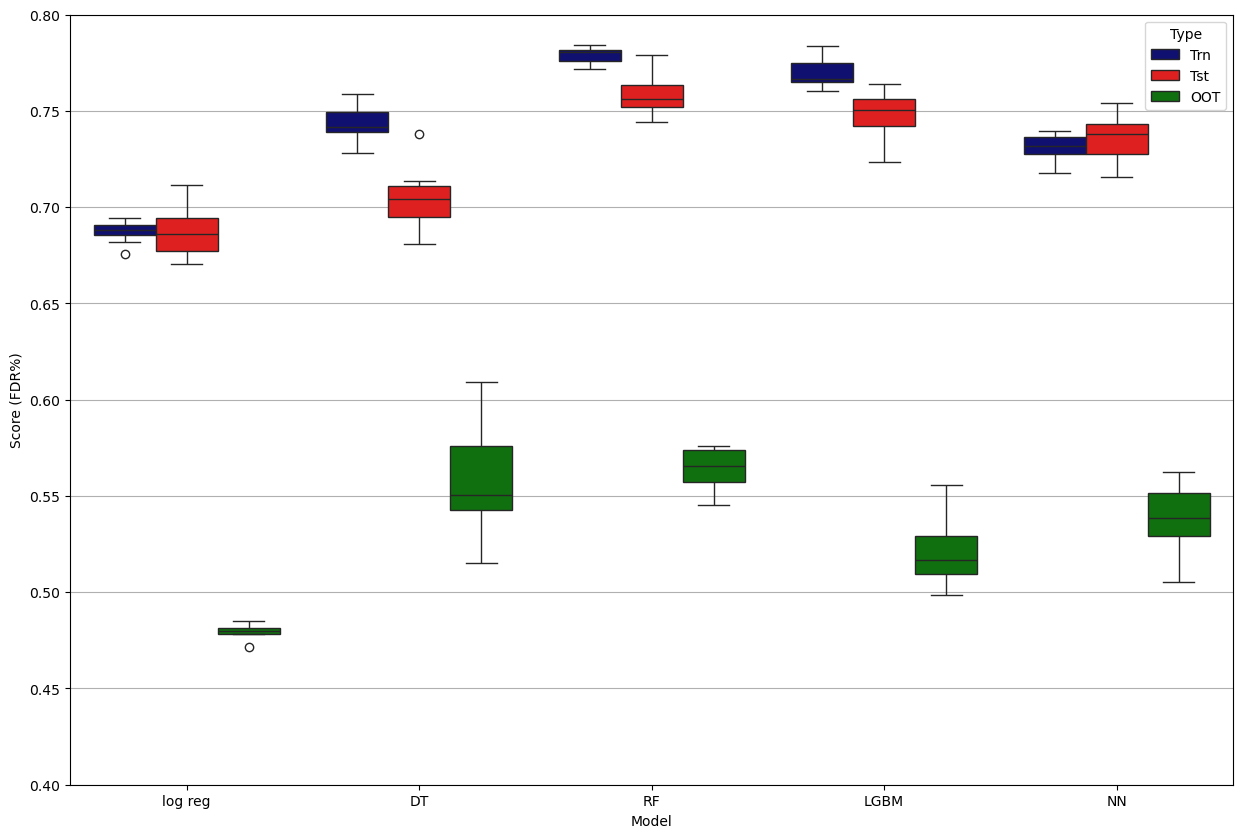

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,.8)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [58]:
print('duration: ', datetime.now() - start_time)

duration:  0:01:16.112917


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [83]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .52
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = lgb.LGBMClassifier(subsample=1, max_depth=2, learning_rate=0.1, n_estimators=100)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.52
[LightGBM] [Info] Number of positive: 1240, number of negative: 58444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020776 -> initscore=-3.852958
[LightGBM] [Info] Start training from score -3.852958
0 0.7725806451612903 0.7372549019607844 0.5185185185185185
[LightGBM] [Info] Number of positive: 1223, number of negative: 58461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points 

In [106]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [107]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,Cardnum_count_1_by_30_sq,Cardnum_max_14,Card_dow_vdratio_0by7,card_state_max_7,card_zip_count_1_by_60_sq,Merchnum_desc_total_3,Cardnum_unique_count_for_card_state_3,Cardnum_actual/toal_1,predicted,Fraud
91007,7.900037,-0.324155,2.305513,-0.185289,1.638749,-0.576554,0.923778,-0.425577,6.158410,-1.580510,0.969788,1
96243,7.900037,-0.322929,2.330397,-0.188352,1.638749,-0.573947,0.923778,-0.424845,6.158410,-1.575458,0.967689,1
88282,9.830472,-0.324090,1.879867,-0.266383,1.638749,-0.576418,0.923778,-0.425538,8.240674,-1.577181,0.967473,1
96458,8.543516,-0.326001,1.691996,-0.153790,1.638749,-0.462963,0.923778,-0.426679,7.720108,-1.582243,0.966401,1
90973,7.256559,-0.328227,2.264040,-0.185289,1.638749,0.013495,0.923778,-0.428008,5.637844,-1.583783,0.966401,1
90868,5.969603,-0.292024,2.062083,-0.185289,1.638749,0.395945,0.923778,0.265150,4.596712,-1.541629,0.966355,1
95264,10.094246,2.809200,0.914017,0.384712,1.638749,1.457521,0.105104,3.631829,9.281806,-1.503470,0.964268,0
90999,7.256559,-0.320532,2.285445,-0.185289,1.638749,-0.443457,0.923778,-0.423414,5.637844,-1.577521,0.964074,1
88288,9.830472,-0.325936,1.906733,-0.266383,1.638749,0.175251,0.923778,-0.426641,8.240674,-1.579293,0.963835,1
90856,5.326124,-0.325835,1.932255,-0.293840,1.638749,-0.580130,0.923778,-0.426580,4.076147,-1.576209,0.963810,0


In [108]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,20.0,102.0,16.393443,83.606557,122.0,20.0,102.0,0.167574,34.343434,34.175860,0.196078
2,2.0,123.0,98.0,25.0,79.674797,20.325203,245.0,118.0,127.0,0.988689,42.760943,41.772254,0.929134
3,3.0,122.0,89.0,33.0,72.950820,27.049180,367.0,207.0,160.0,1.734395,53.872054,52.137659,1.293750
4,4.0,122.0,110.0,12.0,90.163934,9.836066,489.0,317.0,172.0,2.656054,57.912458,55.256404,1.843023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11446.0,297.0,95.902807,100.000000,4.097193,38.538721
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11568.0,297.0,96.925010,100.000000,3.074990,38.949495
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11690.0,297.0,97.947214,100.000000,2.052786,39.360269
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11813.0,297.0,98.977796,100.000000,1.022204,39.774411


Max possible savings: 44,076,000.0


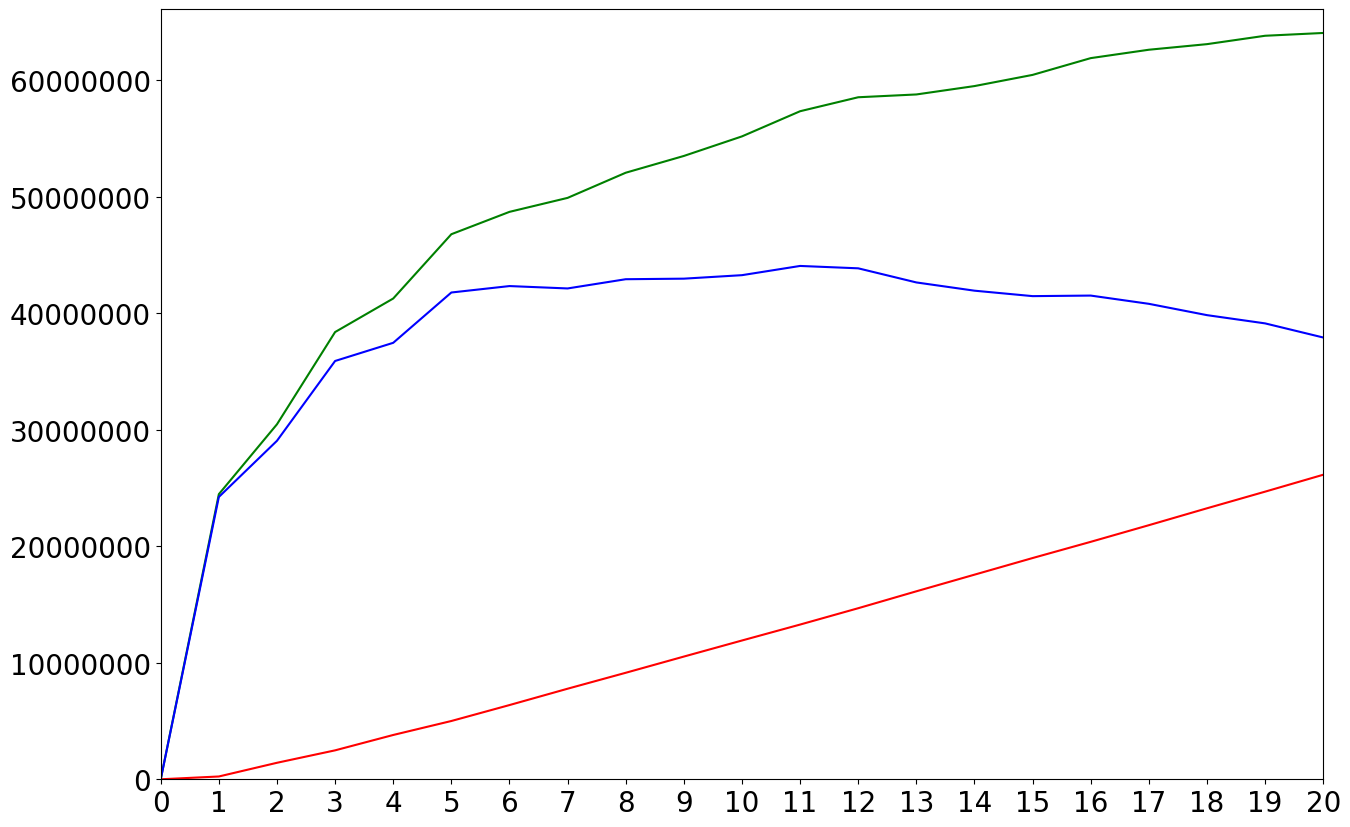

In [109]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [110]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,20.0,102.0,16.393443,83.606557,122.0,20.0,102.0,0.167574,34.343434,34.175860,0.196078
2,2.0,123.0,98.0,25.0,79.674797,20.325203,245.0,118.0,127.0,0.988689,42.760943,41.772254,0.929134
3,3.0,122.0,89.0,33.0,72.950820,27.049180,367.0,207.0,160.0,1.734395,53.872054,52.137659,1.293750
4,4.0,122.0,110.0,12.0,90.163934,9.836066,489.0,317.0,172.0,2.656054,57.912458,55.256404,1.843023
5,5.0,123.0,100.0,23.0,81.300813,18.699187,612.0,417.0,195.0,3.493925,65.656566,62.162640,2.138462
6,6.0,122.0,114.0,8.0,93.442623,6.557377,734.0,531.0,203.0,4.449099,68.350168,63.901069,2.615764
7,7.0,122.0,117.0,5.0,95.901639,4.098361,856.0,648.0,208.0,5.429409,70.033670,64.604261,3.115385
8,8.0,123.0,114.0,9.0,92.682927,7.317073,979.0,762.0,217.0,6.384583,73.063973,66.679390,3.511521
9,9.0,122.0,116.0,6.0,95.081967,4.918033,1101.0,878.0,223.0,7.356514,75.084175,67.727661,3.937220


In [102]:
FDR.to_csv('FDR.csv')

In [105]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [91]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [92]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

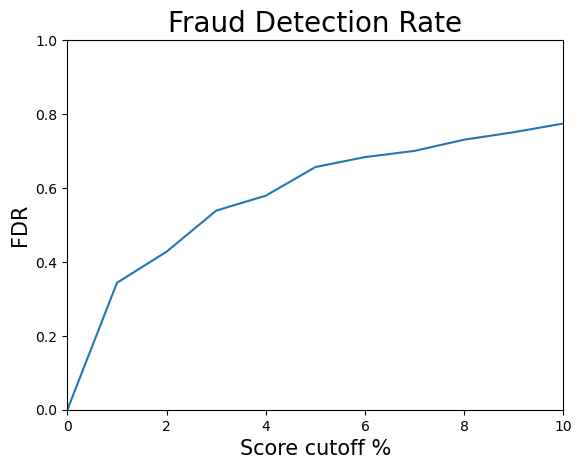

In [93]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

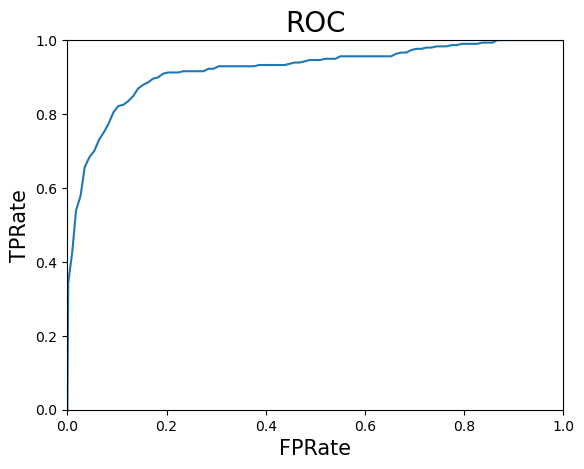

In [94]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [73]:
print("duration: ", datetime.now() - start_time)

duration:  0:04:04.410503


In [74]:
%pwd

'/home/jovyan/Desktop/MSBA/Fraud Analytics/HW5'

In [75]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'card transactions.csv'

In [ ]:
df['prediction'] = model.predict_proba(X)[:,1]

In [ ]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [ ]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000712
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000218
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.016573
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000712
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000264


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [ ]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
63708,63709,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,891.97,1,1.000000
63520,63521,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,809.83,1,0.996498
63919,63920,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,860.35,1,0.996184
63899,63900,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,871.70,1,0.996184
63530,63531,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,726.74,1,0.995729
63535,63536,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,717.17,1,0.995729
63552,63553,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,728.95,1,0.995729
36201,36202,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,2612.16,1,0.995076
50903,50904,5142176939,2010-07-05,4503082476300,OFFICE DEPOT #1082,MD,20763.0,P,1365.00,1,0.994794
67022,67023,5142140316,2010-08-23,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1591.85,1,0.994157


In [ ]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [ ]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: count, dtype: int64

In [ ]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

116

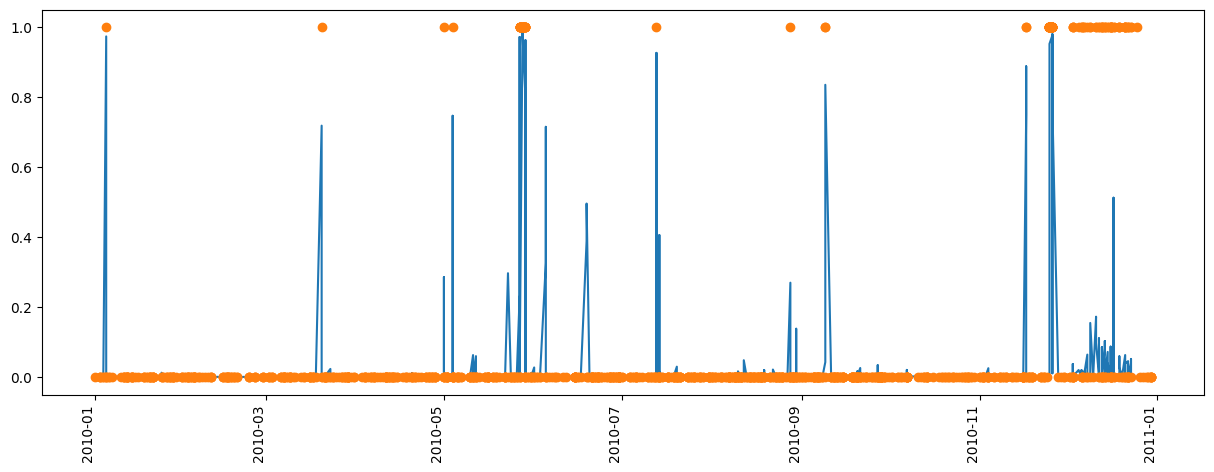

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [ ]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.000668
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001466
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001331
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000101
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.001830


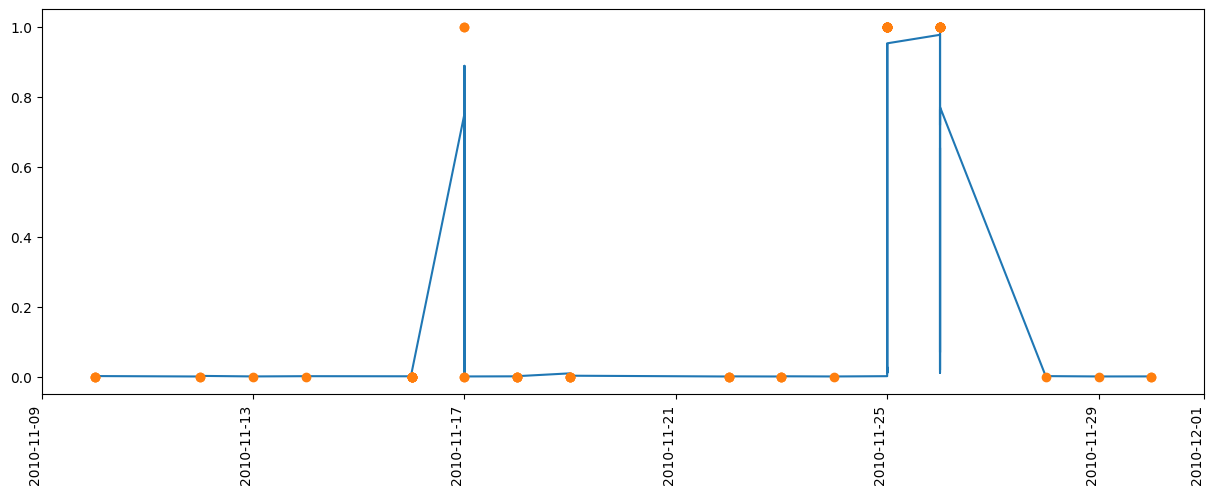

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

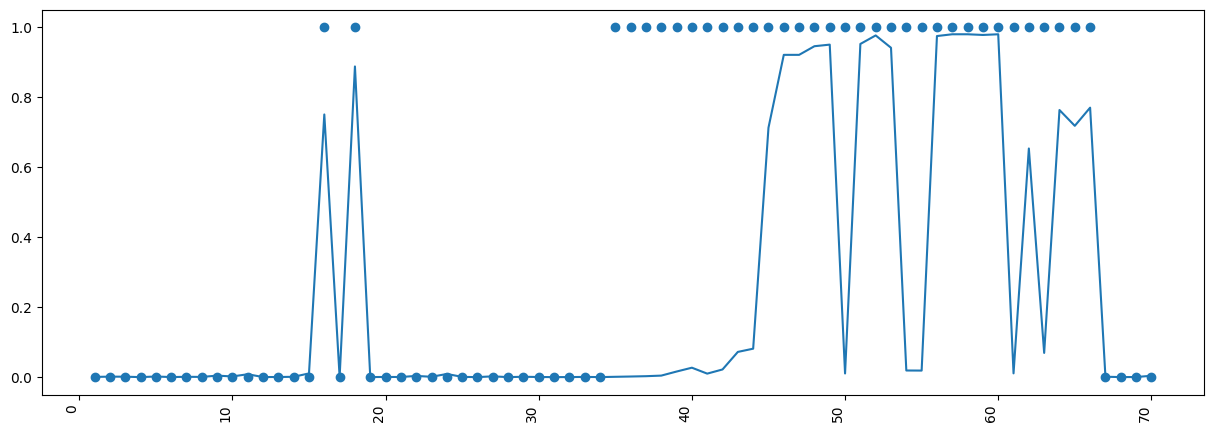

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [ ]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.000668
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001466
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001331
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000101
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.001830
5,6,87948,87949,5142137416,2010-11-13,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.90,0,0.000268
6,7,87964,87965,5142236799,2010-11-14,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,98.60,0,0.000986
7,8,88251,88252,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,32.28,0,0.000675
8,9,88287,88288,5142226979,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.06,0,0.004323
9,10,88393,88394,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,234.54,0,0.002038


# Score Calibration

In [ ]:
base = 700
delta = 40
odds_at_base = 1

In [ ]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 12)

In [ ]:
df.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,predicted,Fraud
35197,0.821777,0.873428,-0.485038,0.660802,0.306509,1.008274,0.367953,0.873320,0.066968,0.522217,0.003128,0
58988,0.821777,-0.307221,-0.441286,0.260552,0.094681,0.300562,-0.398832,-0.307289,0.637131,-1.998142,0.001490,0
68990,-0.465180,0.967079,-0.819611,0.767807,-0.577210,-0.694658,0.487900,0.966969,1.777457,0.659152,0.001231,0
76294,-0.465180,-0.299788,-0.556134,-0.333691,-0.507704,-0.595136,-0.411052,-0.299857,0.066968,0.659152,0.000752,0
13171,-0.465180,-0.187484,-0.722027,0.187534,-0.594587,-0.650426,-0.344000,-0.187556,0.637131,0.659152,0.001398,0


In [ ]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,Fraud
79750,0.000015,0
73250,0.000016,0
28413,0.000016,0
54964,0.000017,0
61983,0.000017,0


In [ ]:
calib.shape

(97496, 2)

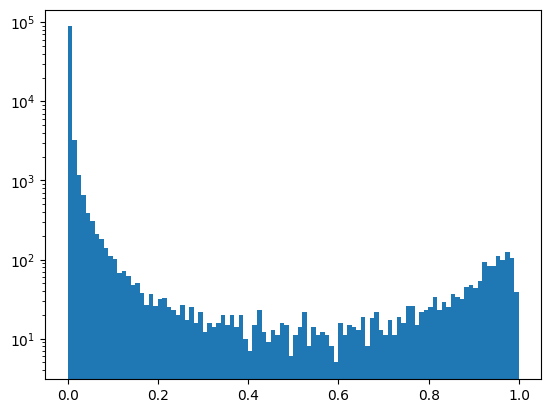

In [ ]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [ ]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [ ]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [ ]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000034,0.000000,0.000001,-13.790193,-8.000000
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000048,0.000000,0.000001,-13.790193,-8.000000
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000059,0.000000,0.000001,-13.790193,-8.000000
4,4.0,975.0,974.0,1.0,99.897436,0.102564,3900.0,3899.0,1.0,0.000069,0.102564,0.001028,-6.880412,-6.880412
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4874.0,1.0,0.000079,0.000000,0.000001,-13.790193,-6.880412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,942.0,33.0,96.615385,3.384615,93600.0,93398.0,198.0,0.034024,3.384615,0.035033,-3.351467,-3.351467
97,97.0,975.0,921.0,54.0,94.461538,5.538462,94575.0,94319.0,252.0,0.057778,5.538462,0.058633,-2.836457,-2.836457
98,98.0,975.0,818.0,157.0,83.897436,16.102564,95550.0,95137.0,409.0,0.144819,16.102564,0.191933,-1.650610,-1.650610
99,99.0,975.0,275.0,700.0,28.205128,71.794872,96525.0,95412.0,1109.0,0.602269,71.794872,2.545458,0.934311,0.934311


In [ ]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,942.0,33.0,96.615385,3.384615,93600.0,93398.0,198.0,0.034024,3.384615,0.035033,-3.351467,-3.351467
97,97.0,975.0,921.0,54.0,94.461538,5.538462,94575.0,94319.0,252.0,0.057778,5.538462,0.058633,-2.836457,-2.836457
98,98.0,975.0,818.0,157.0,83.897436,16.102564,95550.0,95137.0,409.0,0.144819,16.102564,0.191933,-1.650610,-1.650610
99,99.0,975.0,275.0,700.0,28.205128,71.794872,96525.0,95412.0,1109.0,0.602269,71.794872,2.545458,0.934311,0.934311
100,100.0,975.0,37.0,938.0,3.794872,96.205128,97500.0,95449.0,2047.0,0.942640,96.205128,25.351378,3.232833,3.232833


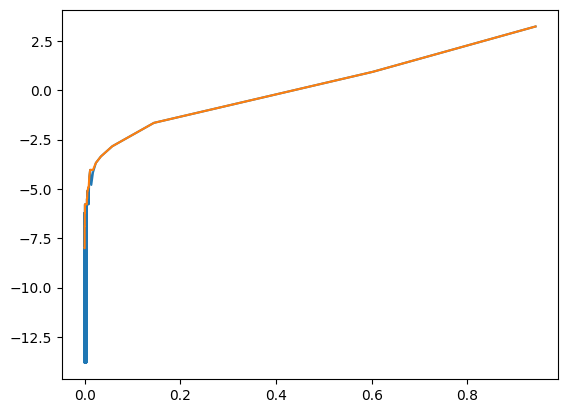

In [ ]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [ ]:
def func(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcinv(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.94188106  0.94013796 -0.00245399]


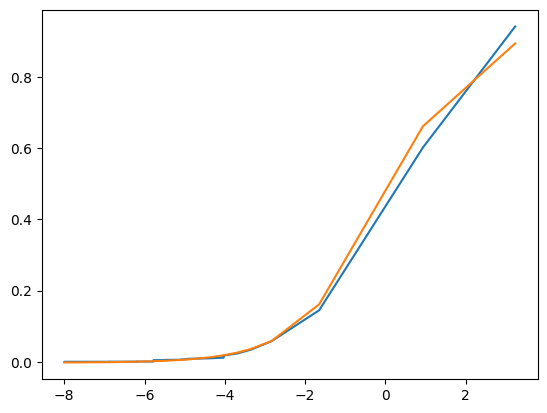

In [ ]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],func(cal_bins['log_odds_adj'], *popt))

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


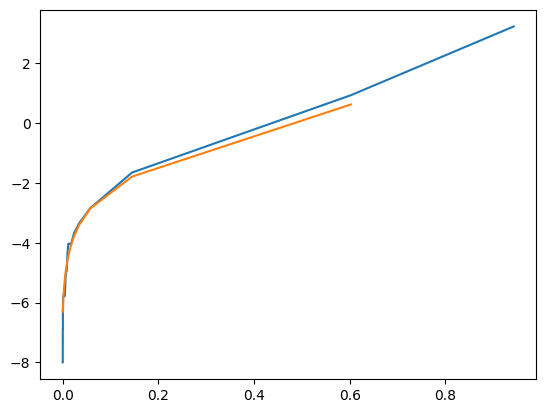

In [ ]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcinv(cal_bins['score_raw'], *popt))

In [ ]:
# The fit looks pretty good
cal_bins['fit'] = funcinv(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000034,0.000000,0.000001,-13.790193,-8.000000,-6.297980
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000048,0.000000,0.000001,-13.790193,-8.000000,-6.292011
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000059,0.000000,0.000001,-13.790193,-8.000000,-6.287371
4,4.0,975.0,974.0,1.0,99.897436,0.102564,3900.0,3899.0,1.0,0.000069,0.102564,0.001028,-6.880412,-6.880412,-6.283008
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4874.0,1.0,0.000079,0.000000,0.000001,-13.790193,-6.880412,-6.278863
6,6.0,975.0,975.0,0.0,100.000000,0.000000,5850.0,5849.0,1.0,0.000090,0.000000,0.000001,-13.790193,-6.880412,-6.274367
7,7.0,975.0,975.0,0.0,100.000000,0.000000,6825.0,6824.0,1.0,0.000101,0.000000,0.000001,-13.790193,-6.880412,-6.269490
8,8.0,975.0,974.0,1.0,99.897436,0.102564,7800.0,7798.0,2.0,0.000114,0.102564,0.001028,-6.880412,-6.880412,-6.264174
9,9.0,975.0,975.0,0.0,100.000000,0.000000,8775.0,8773.0,2.0,0.000127,0.000000,0.000001,-13.790193,-6.880412,-6.258853
10,10.0,975.0,975.0,0.0,100.000000,0.000000,9750.0,9748.0,2.0,0.000140,0.000000,0.000001,-13.790193,-6.880412,-6.253712


In [ ]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [ ]:
calib.head()

,score_raw,Fraud
79750,0.000015,0
73250,0.000016,0
28413,0.000016,0
54964,0.000017,0
61983,0.000017,0


In [ ]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcinv(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,score_raw,Fraud,score_calib
79750,0.000015,0,447.752999
73250,0.000016,0,447.770557
28413,0.000016,0,447.773032
54964,0.000017,0,447.787687
61983,0.000017,0,447.791153


In [ ]:
calib.tail()

,score_raw,Fraud,score_calib
63316,0.995152,1,999.0
63699,0.995607,1,999.0
63679,0.995607,1,999.0
63301,0.995921,1,999.0
63489,0.999000,1,999.0


In [ ]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.019922,0.020996,479.378238
std,0.113032,0.143371,61.498662
min,0.000015,0.000000,447.752999
25%,0.000406,0.000000,454.017195
50%,0.001052,0.000000,462.699916
75%,0.002680,0.000000,478.964872
max,0.999000,1.000000,999.000000


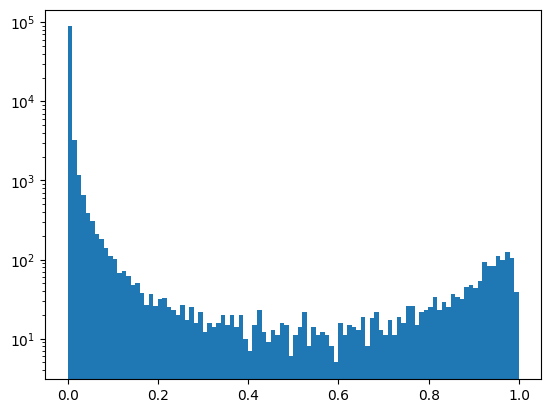

In [ ]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

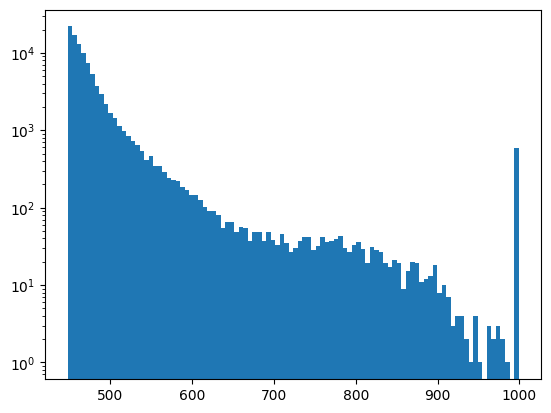

In [ ]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

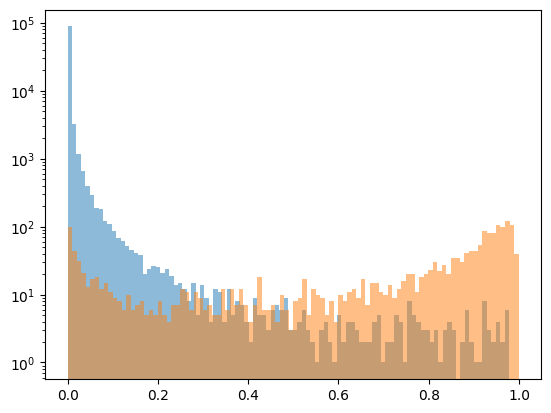

In [ ]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

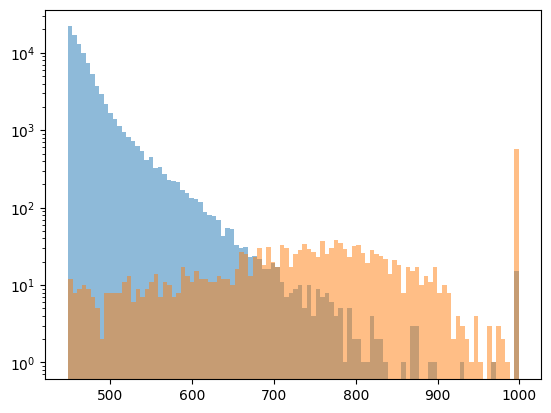

In [ ]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
print("duration: ", datetime.now() - start_time)

duration:  0:01:19.553737


In [ ]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/UCSD/2024 Spring Fraud/Classes'